In [1]:
!git clone https://github.com/shawLyu/HR-Depth
%cd HR-Depth/

Cloning into 'HR-Depth'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 8), reused 39 (delta 4), pack-reused 0
Unpacking objects: 100% (45/45), 16.20 MiB | 5.45 MiB/s, done.
/content/HR-Depth


In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

import networks

In [3]:
depth_encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.HRDepthDecoder(depth_encoder.num_ch_enc)

depth_encoder_path = "./models/HR_Depth_K_M_1280x384/encoder.pth"
depth_decoder_path = "./models/HR_Depth_K_M_1280x384/depth.pth"

encoder_dict = torch.load(depth_encoder_path)
img_height = encoder_dict["height"]
img_width = encoder_dict["width"]
print("Test image height is:", img_height)
print("Test image width is:", img_width)
load_dict = {k: v for k, v in encoder_dict.items() if k in depth_encoder.state_dict()}

decoder_dict = torch.load(depth_decoder_path)

depth_encoder.load_state_dict(load_dict)
depth_decoder.load_state_dict(decoder_dict)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test image height is: 384
Test image width is: 1280


<All keys matched successfully>

In [4]:
import torch.onnx

depth_encoder.eval()
dummy_input_a = torch.randn(1, 3, img_height, img_width)

# export the model
torch.onnx.export(depth_encoder,
    dummy_input_a,
    "./depth_encoder.onnx",
    export_params=True,
    #opset_version=10,
    do_constant_folding=True,
    input_names=["input.0"],
    output_names=["output.0", "output.1", "output.2", "output.3", "output.4"],
    #dynamic_axes={}
    )

depth_decoder.eval()
dummy_input0 = torch.randn(1,  64, 192, 640)
dummy_input1 = torch.randn(1,  64,  96, 320)
dummy_input2 = torch.randn(1, 128,  48, 160)
dummy_input3 = torch.randn(1, 256,  24,  80)
dummy_input4 = torch.randn(1, 512,  12,  40)
dummy_input_b  = [dummy_input0,dummy_input1,dummy_input2,dummy_input3,dummy_input4]

# export the model
torch.onnx.export(depth_decoder,
    dummy_input_b,
    "./depth_decoder.onnx",
    export_params=True,
    #opset_version=10,
    do_constant_folding=True,
    input_names=["input.0", "input.1", "input.2", "input.3", "input.4"],
    output_names=["scale0", "scale1", "scale2", "sacle3"],
    #dynamic_axes={}
    )

/usr/local/lib/python3.8/dist-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.8/dist-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered i

torch.Size([1, 3, 384, 1280])


Text(0.5, 1.0, 'Disparity Prediction')

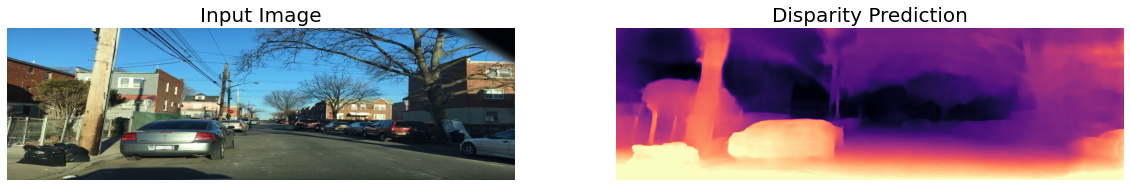

In [5]:
img_path = "./sample.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (img_width, img_height))

image_tensor = transforms.ToTensor()(image).unsqueeze(0)
print(image_tensor.shape)

# predict depth from single image
result1 = depth_encoder(image_tensor)
result  = depth_decoder(result1)

#print(result1)
#print(result)

disparity = result[("disparity", "Scale0")].cpu().detach().squeeze().numpy()
vmax = np.percentile(disparity, 95)
# show prediction result
plt.figure(figsize=(20,5))
plt.subplot(121);plt.imshow(image);plt.axis('off');plt.title("Input Image",fontsize=20)
plt.subplot(122);plt.imshow(disparity, vmax=vmax, cmap="magma");plt.axis('off');plt.title("Disparity Prediction", fontsize=20)